# Electrocardiogram Beat Classification
Haotian Zhuang, Jasprit Singh Aujla, Claire Gu, Zhishuai Liu



## Introduction



An electrocardiogram (ECG) records the electrical activity of the heart; it contains rich pathological information on cardiovascular diseases, such as arrhythmia. However, it is difficult to visually analyze ECG signals due to their complexity and nonlinearity. We use the MIT-BIH Arrhythmia Database to develop machine learning methods for ECG beat classification. The MIT-BIH database contains 48 half-hour excerpts of two-channel ambulatory ECG recordings, obtained from 47 subjects studied by the BIH Arrhythmia Laboratory between 1975 and 1979. We plan to first do some data preprocessing to transform the ECG records to single heartbeats. Then split training and testing data. Finally, we train several models, KNN, SVM, decision tree and random forest, to classify the heartbeats using training data and then compare the models on the testing data. 

## Setup

In [7]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold, RandomizedSearchCV

## Data Processing

The original MIT-BIH Arrhythmia Database is not directly analyzable. We refer  https://nbviewer.org/github/jorge4larcon/mitbih_processor/blob/main/demo.ipynb to extract ECG signals from the Dataset, and save the extracted information in data/ecg_signals.mat. 

This process needs time and cumbersome, so we wrap it in another ipynb file named 'Data Preprocessing'. And skipping of the 'Data Preprocessing.ipynb' file will not affect understanding our project.

There are five type Arrhythmia in the MIT-BIH Database, which are Normal beat (N), Atrial premature beat (A), Premature ventricular contraction (V), Left bundle branch block beat(L), Right bundle branch block beat(R). The original dataset contains 74512 signals of N, 2546 signals of A, 6902 signals of V, 8072 signals of L and 7257 signals of R. On the one hand, the sample sizes in the five classes are unbalanced. On the other hand, the total sample size is too large for this project. Hence we randomly keep 2000 signals in each class as the training set, 500 signals in each class as the testing set.
Thus, our training set contains 10000 instances of single heartbeat ECG records and our testing set contains 2000 samples.

In [8]:
Training_data = pd.read_csv('Training_data.csv')
Testing_data = pd.read_csv('Testing_data.csv')

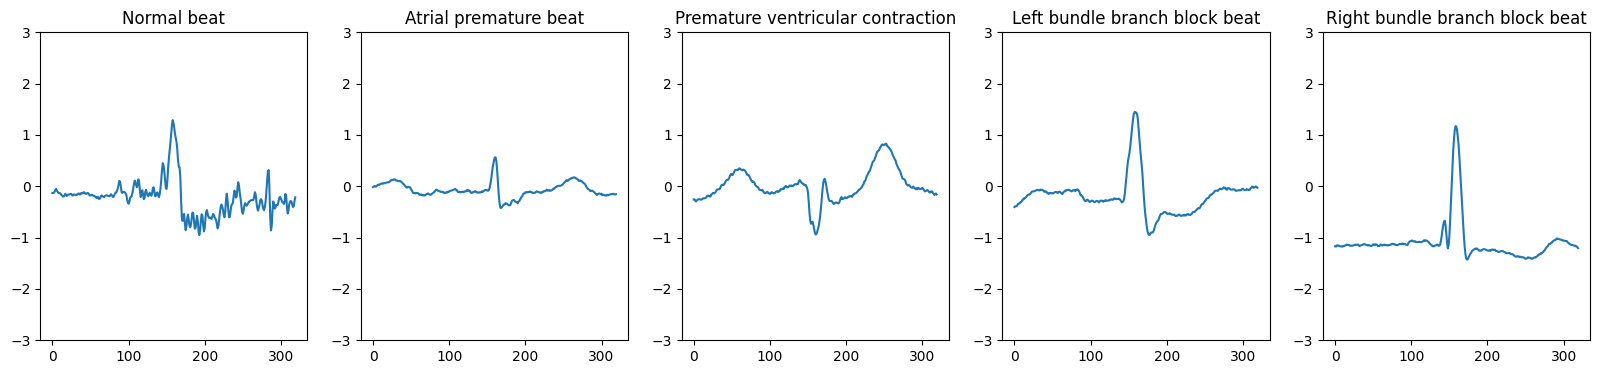

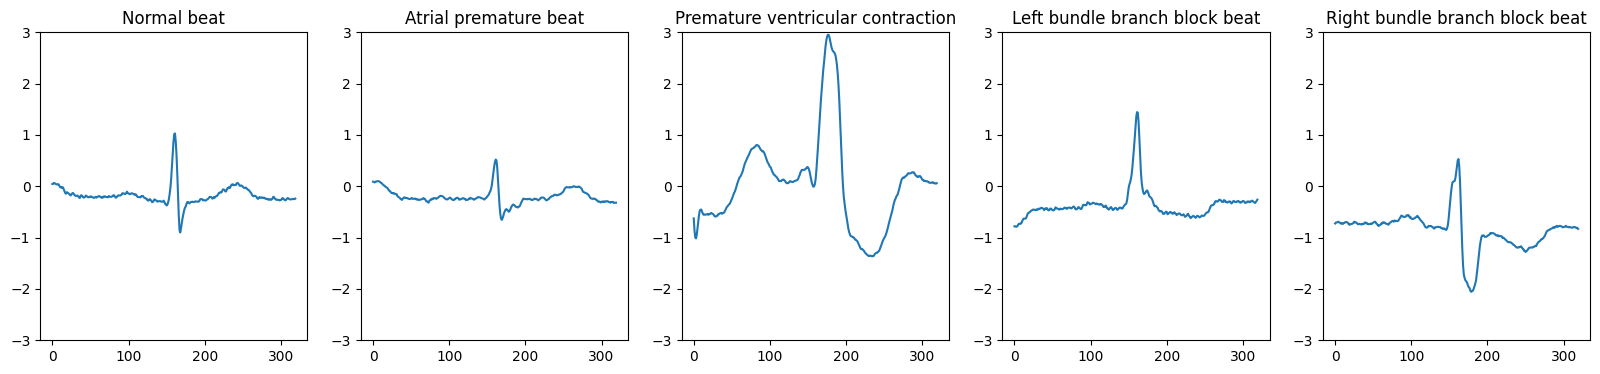

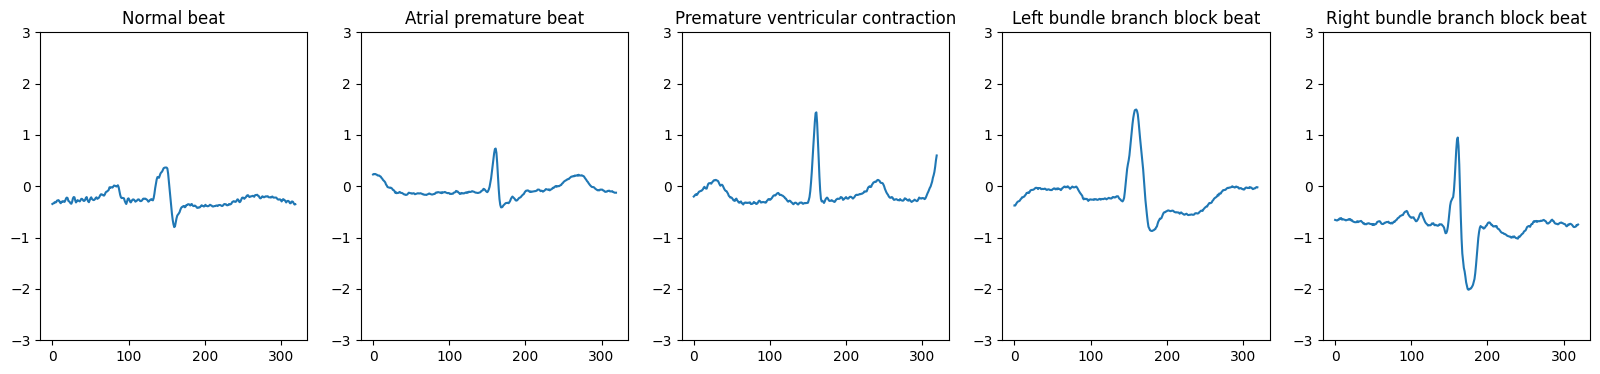

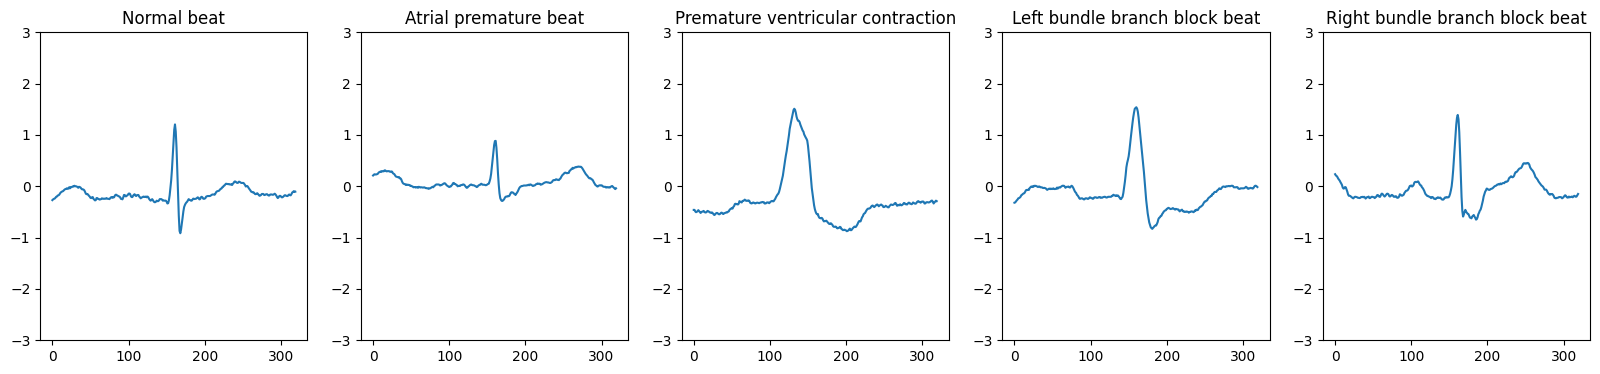

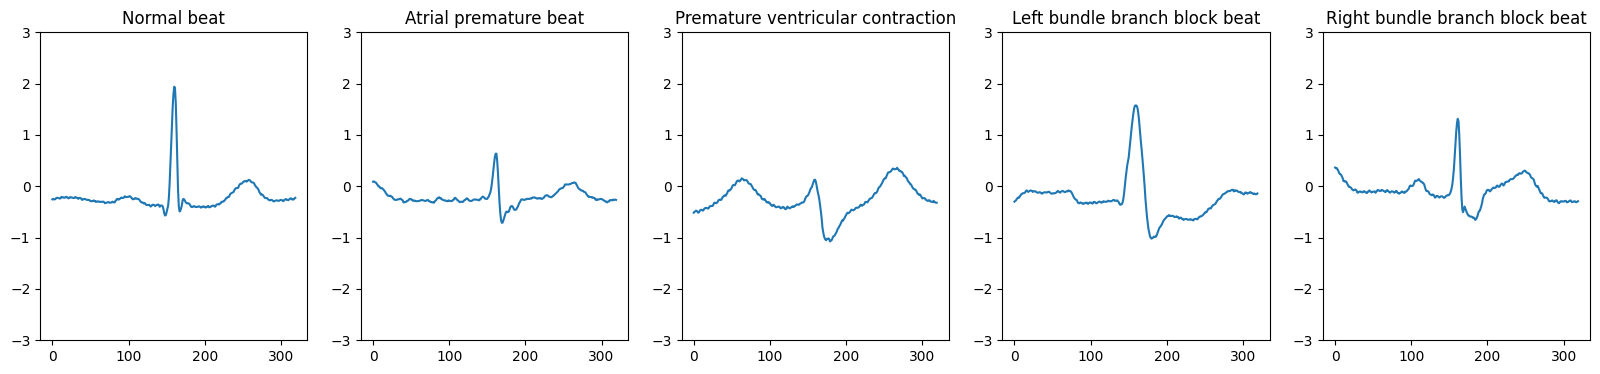

In [9]:
# Plot the signals
x = range(0, 320)
for i in range(0, 1000, 200):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))    
    ax1.set_title('Normal beat')
    ax1.plot(x, list(Training_data.iloc[i+1000,:-1]))
    ax1.set_ylim([-3, 3])
    ax2.set_title('Atrial premature beat')
    ax2.plot(x, list(Training_data.iloc[i+3000,:-1]))
    ax2.set_ylim([-3, 3])    
    ax3.set_title('Premature ventricular contraction')
    ax3.plot(x, list(Training_data.iloc[i+5000,:-1]))
    ax3.set_ylim([-3, 3])    
    ax4.set_title('Left bundle branch block beat')
    ax4.plot(x, list(Training_data.iloc[i+7000,:-1]))
    ax4.set_ylim([-3, 3])
    ax5.set_title('Right bundle branch block beat')
    ax5.plot(x, list(Training_data.iloc[i+9000,:-1]))
    ax5.set_ylim([-3, 3])    
    plt.show()

We conclude from the above figures that different types of arrhythmia have different patterns, and these patterns are too complicated for naked eye recognition. We propose to use machine learning methods for arrhythmia pattern recognition. 

## Method 1 - KNN

We first use K-Nearest Neighbors (KNN) for classification. Hyper-parameters "number of neighbors" are tuned using 10-fold stratified cross-validation on the training set, and the candidate of "number of neighbors" is from 1 to 9. To be specific, param_grid = {'n_neighbors': np.arange(1, 10)}, cv = StratifiedKFold(n_splits = 10), and scoring = 'accuracy'. The result shows the KNN with one neighbor has the best accuracy 95%. Another advantage is that the computation time for KNN is very short. We also print the results for all "number of neighbors" candidates and find that one neighbor does have the best performance, but does not have significant difference with other cases.

In [10]:
X_train = Training_data.drop('Label', axis = 1)
Y_train = Training_data['Label']
X_test = Testing_data.drop('Label', axis = 1)
Y_test = Testing_data['Label']

In [11]:
# Create a KNN classifier
knn = KNeighborsClassifier()

# Set up the hyperparameter which we want to tune
param_grid = {'n_neighbors': np.arange(1, 10)}

# Define the stratified K-fold cross-validation splitter
cv_splitter = StratifiedKFold(n_splits = 10)

# Perform GridSearchCV with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(knn, param_grid, cv = cv_splitter, scoring = 'accuracy')
grid_search.fit(X_train, Y_train)

# Print the best hyperparameters and the corresponding mean accuracy
print("Best hyperparameters:", grid_search.best_params_)
print("Best mean accuracy:", grid_search.best_score_)

best_knn = grid_search.best_estimator_
best_knn.score(X_train, Y_train)

pred_knn = best_knn.predict(X_test)

# Evaluate the accuracy of the predictions
accuracy_knn = accuracy_score(Y_test, pred_knn)
print("Accuracy:", accuracy_knn)

Best hyperparameters: {'n_neighbors': 1}
Best mean accuracy: 0.9479000000000001
Accuracy: 0.9564


In [12]:
# Get the mean test scores for each hyperparameter value
results = grid_search.cv_results_
mean_test_scores = results['mean_test_score']

# Print the mean test score for each hyperparameter value
for i, score in enumerate(mean_test_scores):
    params = results['params'][i]
    print("Hyperparameters:", params, "Mean test score:", score)

Hyperparameters: {'n_neighbors': 1} Mean test score: 0.9479000000000001
Hyperparameters: {'n_neighbors': 2} Mean test score: 0.9442
Hyperparameters: {'n_neighbors': 3} Mean test score: 0.9447999999999999
Hyperparameters: {'n_neighbors': 4} Mean test score: 0.9427
Hyperparameters: {'n_neighbors': 5} Mean test score: 0.9428999999999998
Hyperparameters: {'n_neighbors': 6} Mean test score: 0.9388
Hyperparameters: {'n_neighbors': 7} Mean test score: 0.9375
Hyperparameters: {'n_neighbors': 8} Mean test score: 0.9356
Hyperparameters: {'n_neighbors': 9} Mean test score: 0.9326000000000001


In [13]:
# predict probabilities of test set
y_proba = best_knn.predict_proba(X_test)

# calculate AUC score
auc_score_knn = roc_auc_score(Y_test, y_proba, multi_class = 'ovr')
print('AUC score:', auc_score_knn)

AUC score: 0.9727499999999999


In [14]:
# Classification report 
print("K-Nearest Neighbors classification report:")
print(classification_report(Y_test, pred_knn))

K-Nearest Neighbors classification report:
              precision    recall  f1-score   support

           A       0.96      0.94      0.95       500
           L       0.99      0.99      0.99       500
           N       0.89      0.94      0.91       500
           R       0.98      0.99      0.98       500
           V       0.96      0.93      0.94       500

    accuracy                           0.96      2500
   macro avg       0.96      0.96      0.96      2500
weighted avg       0.96      0.96      0.96      2500



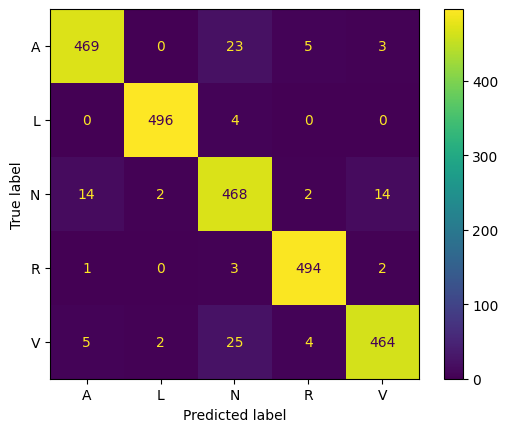

In [15]:
cm = confusion_matrix(Y_test, pred_knn, labels = best_knn.classes_)
# cm
ConfusionMatrixDisplay.from_predictions(Y_test, pred_knn, include_values = True)
plt.show()

## Method 2 - Decision Tree

##### For Decision Tree, we used the param_grid with "criterion": ["gini", "entropy"] and "max_depth": [5, 10, 25, 40, 50], cv = StratifiedKFold(n_splits = 10) and scoring="accuracy". The final result showed that gini with max_depth=25 are the best classifier with the accuracy 88%. The accuracy was not that high compared to k-Nearest Neighbors and moreover, the computation time was fairly long. 

In [16]:
# Define the decision tree classifier
tree = DecisionTreeClassifier(random_state=42)

# Define the hyperparameters to tune
param_grid = {'criterion': ['gini', 'entropy'], 
              'max_depth': [5, 10, 25, 40, 50]}

# Define the stratified K-fold cross-validation splitter
cv_splitter = StratifiedKFold(n_splits=10)

# Perform grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(tree, param_grid, cv=cv_splitter, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# Print the best hyperparameters and the corresponding mean accuracy
print("Best hyperparameters:", grid_search.best_params_)
print("Best mean accuracy:", grid_search.best_score_)

# Fit the decision tree classifier with the best hyperparameters on the training data
best_tree = grid_search.best_estimator_
best_tree.fit(X_train, Y_train)

# Predict the classes of the test data
pred_tree = best_tree.predict(X_test)

# Evaluate the accuracy of the predictions
accuracy_tree = accuracy_score(Y_test, pred_tree)
print("Accuracy:", accuracy_tree)

Best hyperparameters: {'criterion': 'gini', 'max_depth': 25}
Best mean accuracy: 0.8870000000000001
Accuracy: 0.88


In [17]:
# Get the mean test scores for each hyperparameter value
results = grid_search.cv_results_
mean_test_scores = results['mean_test_score']

# Print the mean test score for each hyperparameter value
for i, score in enumerate(mean_test_scores):
    params = results['params'][i]
    print("Hyperparameters:", params, "Mean test score:", score)

Hyperparameters: {'criterion': 'gini', 'max_depth': 5} Mean test score: 0.7673000000000001
Hyperparameters: {'criterion': 'gini', 'max_depth': 10} Mean test score: 0.8724000000000001
Hyperparameters: {'criterion': 'gini', 'max_depth': 25} Mean test score: 0.8870000000000001
Hyperparameters: {'criterion': 'gini', 'max_depth': 40} Mean test score: 0.8855999999999999
Hyperparameters: {'criterion': 'gini', 'max_depth': 50} Mean test score: 0.8853
Hyperparameters: {'criterion': 'entropy', 'max_depth': 5} Mean test score: 0.7792000000000001
Hyperparameters: {'criterion': 'entropy', 'max_depth': 10} Mean test score: 0.8789
Hyperparameters: {'criterion': 'entropy', 'max_depth': 25} Mean test score: 0.8855000000000001
Hyperparameters: {'criterion': 'entropy', 'max_depth': 40} Mean test score: 0.8855000000000001
Hyperparameters: {'criterion': 'entropy', 'max_depth': 50} Mean test score: 0.8855000000000001


In [19]:
# Predict the probabilities of the test data
y_proba = best_tree.predict_proba(X_test)

# Calculate the AUC score
auc_score_tree = roc_auc_score(Y_test, y_proba, multi_class='ovr')
print('AUC score:', auc_score_tree)

AUC score: 0.9226788000000001


In [20]:
print("Decision Tree classification report:")
print(classification_report(Y_test, pred_tree))

Decision Tree classification report:
              precision    recall  f1-score   support

           A       0.87      0.85      0.86       500
           L       0.92      0.94      0.93       500
           N       0.80      0.81      0.80       500
           R       0.94      0.94      0.94       500
           V       0.88      0.86      0.87       500

    accuracy                           0.88      2500
   macro avg       0.88      0.88      0.88      2500
weighted avg       0.88      0.88      0.88      2500



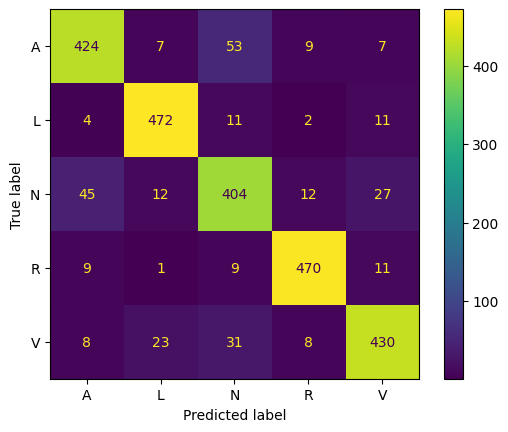

In [21]:
# Compute the confusion matrix
cm = confusion_matrix(Y_test, pred_tree, labels=best_tree.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_tree.classes_)
disp.plot()
plt.show()

## Method 4 - Random forest

For Random Forest, we used the random_grid with “n_estimators”: [50,100,200,300] and “max_features”: ['sqrt],"max_depth":[3,5,7,9],"min_samples_split":[1,2,4],"bootsrap":[True,False], and cv = StratifiedKFold(n_splits = 10). The final result showed the best classifier with the accuracy 93% and the AUC 0.99. However, the computation time was fairly long.

In [22]:
Training_data = pd.read_csv('Training_data.csv')
Testing_data = pd.read_csv('Testing_data.csv')
# convert the categorical features into numeric attributes
Training_data.Label = pd.Categorical(Training_data.Label)
Testing_data.Label = pd.Categorical(Testing_data.Label)
Training_data['La'] = Training_data.Label.cat.codes
Testing_data['La'] = Testing_data.Label.cat.codes
Training_data = Training_data.drop(columns=['Label'])
Testing_data= Testing_data.drop(columns=['Label'])
Training_data = Training_data.rename(columns={"La": "Label"})
Testing_data= Testing_data.rename(columns={"La": "Label"})

In [23]:
X_train = Training_data.drop('Label', axis = 1)
Y_train = Training_data['Label']
X_test = Testing_data.drop('Label', axis = 1)
Y_test = Testing_data['Label']

In [24]:
# Number of trees in random forest
n_estimators = [50,100,200,300]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [3,5,7,9]
# Minimum number of samples required to split a node
min_samples_split = [2, 5,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [25]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Define the stratified K-fold cross-validation splitter
cv_splitter = StratifiedKFold(n_splits=10)
# Random search of parameters, using 10 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = cv_splitter)
# Fit the random search model
rf_random.fit(X_train, Y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 5, 7, 9],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300]})

In [26]:
# Print the best hyperparameters and the corresponding mean accuracy
print("Best hyperparameters:", rf_random.best_params_)
print("Best mean accuracy:", rf_random.best_score_)

Best hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 9, 'bootstrap': False}
Best mean accuracy: 0.9208000000000001


Accuracy: 0.9284
AUC score: 0.9921518


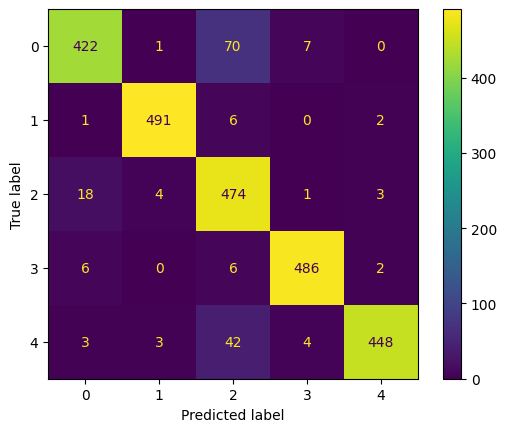

In [31]:
# Fit the random forest classifier with the best hyperparameters on the training data
best_tree = rf_random.best_estimator_
best_tree.fit(X_train, Y_train)

# Predict the classes of the test data
pred_tree = best_tree.predict(X_test)

# Evaluate the accuracy of the predictions
accuracy_forest = accuracy_score(Y_test, pred_tree)
print("Accuracy:", accuracy_forest)

# Predict the probabilities of the test data
y_proba = best_tree.predict_proba(X_test)

# Calculate the AUC score
auc_score_forest = roc_auc_score(Y_test, y_proba, multi_class='ovr')
print('AUC score:', auc_score_forest)

# Compute the confusion matrix
cm = confusion_matrix(Y_test, pred_tree, labels=best_tree.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_tree.classes_)
disp.plot()
plt.show()

In [28]:
print("Random Forest classification report:")
print(classification_report(Y_test, pred_tree))

Random Forest classification report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       500
           1       0.98      0.98      0.98       500
           2       0.81      0.95      0.87       500
           3       0.97      0.96      0.97       500
           4       0.98      0.89      0.94       500

    accuracy                           0.93      2500
   macro avg       0.94      0.93      0.93      2500
weighted avg       0.94      0.93      0.93      2500



## Comparison & Conclusions

We also tried Support Vector Machine (SVM), but the training time for SVM is so long and the result is not the best that we omit it in our project. We present the metric assessing three models in a neat form. 

In [29]:
comparision = [[accuracy_knn, auc_score_knn], 
               [accuracy_tree, auc_score_tree], 
               [accuracy_forest, auc_score_forest]]
comp = pd.DataFrame(comparision, index = ['KNN', 'DT', 'RF'], columns = ['Accuracy', 'AUC Score'])
comp

,Accuracy,AUC Score
KNN,0.9564,0.972750
DT,0.8800,0.922679
RF,0.9312,0.992214


We conclude that KNN with k equals to 1 triumps other methods upon accuracy and it is also the least time costing method. Decision tree is the worst method with low accuracy, low AUC score and long training time. It is unsurprising that decision tree cannot depict the patterns of this kind of 1-d signals. Random Forest uses the longest training time, though it has the highest AUC score. In this multi-class classification task, we mainly focus on accuracy and take AUC score as an axiliary metric to assess the performances of different methods. In conclusion, the KNN is the best model for our task of ECG beat classification. 